# <font color='magenta'>1_Kernels_vs_BG_10312022_KD_Fig2a</font> 

This script is used to analyze the wheat kernel HSI data (VISNIR), written by Kshitiz Dhakal.

Healthy status:

Kernel(Healthy-looking(75) and Infected-looking(53))- 128

Background-68 data points

Total: 196

Labels:   
   Kernel(Healthy-looking and Infected-looking)-1
   
   Background-0

### Packages and versions:
Python 3.8.6
scipy: 1.6.0
numpy: 1.18.5
matplotlib: 3.3.3
pandas: 1.2.1
sklearn: 1.0.2
xgboost: 1.5.1
seaborn: 0.11.1

### Import libraries and check their versions

In [1]:
import sys
print('Python: {}'.format(sys.version))
import scipy
print('scipy: {}'.format(scipy.__version__))
import numpy
print('numpy: {}'.format(numpy.__version__))
import matplotlib
import pandas
print('pandas: {}'.format(pandas.__version__))
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
import xgboost
print('xgboost: {}'.format(xgboost.__version__))
import seaborn
print('sns: {}'.format(xgboost.__version__))

Python: 3.8.6 | packaged by conda-forge | (default, Dec 26 2020, 04:30:06) [MSC v.1916 64 bit (AMD64)]
scipy: 1.6.0
numpy: 1.23.4
pandas: 1.2.1
sklearn: 1.0.2
xgboost: 1.5.1
sns: 1.5.1


### Load packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import spectral # spectral python (SPy) module for processing hyperspectral images
import spectral.io.envi as envi # load hyperspectral image with ENVI header files
import seaborn as sns
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from numpy import mean
from numpy import std
from pandas import read_csv
from xgboost import XGBClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB #generative and supervised
from sklearn.neighbors import KNeighborsClassifier #discriminative and supervised
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #discriminative and supervised
from sklearn.neural_network import MLPClassifier #discriminative and supervised
from sklearn.cross_decomposition import PLSRegression #discriminative and supervised
from sklearn.ensemble import RandomForestClassifier #discriminative and supervised
from sklearn import svm
from sklearn.svm import SVC #discriminative and supervised
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold # for five fold cross validation
from sklearn.metrics import confusion_matrix # calcuate confusion matrix
from statannotations.Annotator import Annotator

### Load and pre-process the dataset 
#### The original dataset was labeled taking background pixels as 0 and kernel pixels as 1

In [3]:
dataset = pd.read_csv('../Input/input_hsi_2022_coded_two_classes_refined.csv', index_col=0)

#### Extract information from the orginal dataset

In [4]:
array = dataset.values # save all the values of datasets as array
labels = array[:,300] # save the labels
features = array[:,0:300] # save the reflectance values of classified pixels as features
features = features/20000 # normalize features
wavelengths = dataset.columns[0:300] # save the column names as wavelengths

#### Rebuild the dataframe to visualize hyperspectral signatures

In [5]:
df = pd.DataFrame(features) #Create a new df having reflecance values only
df_wave = pd.DataFrame(wavelengths) # Add wavelengths in the df
df_wave.columns = ['Wavelength(nm)'] # Add a new column named Wavelength(nm) 
df.columns = df_wave['Wavelength(nm)'] # Add the previous column to the df
df['Label'] = labels # Add labels to the df
df.head() #Display head of df
df

Wavelength(nm),385.63,387.65,389.67,391.68,393.7,395.72,397.74,399.76,401.79,403.81,...,1009,1011.27,1013.54,1015.81,1018.08,1020.35,1022.63,1024.9,1027.18,Label
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.05045,0.01375,0.00000,0.00890,...,0.00000,0.00000,0.00000,0.09255,0.00000,0.00000,0.00000,0.00000,0.00000,0
1,0.00000,0.00000,0.04840,0.01785,0.00000,0.03885,0.06460,0.05290,0.02825,0.04595,...,0.04555,0.00000,0.00000,0.00000,0.00000,0.00000,0.13255,0.00000,0.00000,0
2,0.00000,0.02415,0.10315,0.06490,0.10695,0.10805,0.11650,0.09390,0.14125,0.13865,...,0.04260,0.04555,0.05100,0.00000,0.05370,0.06275,0.13390,0.00000,0.00000,0
3,0.00000,0.00000,0.00000,0.00000,0.07770,0.06380,0.03480,0.02840,0.02265,0.04615,...,0.00000,0.10065,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0
4,0.06490,0.00000,0.03845,0.03130,0.00000,0.00000,0.01740,0.02785,0.00000,0.01900,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.03585,0.06650,0.02350,0.04010,0.04780,0.07975,0.05480,0.06235,0.05110,0.06535,...,0.14950,0.27075,0.21895,0.25210,0.11705,0.13695,0.36760,0.26625,0.17875,1
192,0.00000,0.17595,0.07020,0.00000,0.00000,0.05815,0.03215,0.06755,0.03240,0.04380,...,0.00000,0.15625,0.18435,0.00000,0.18670,0.11360,0.00000,0.00000,0.00000,1
193,0.00000,0.00000,0.00000,0.02790,0.04900,0.05770,0.07995,0.05175,0.10495,0.05095,...,0.20085,0.07575,0.17750,0.09375,0.18750,0.20270,0.00000,0.00000,0.14285,1
194,0.07040,0.10730,0.06540,0.10710,0.06980,0.09490,0.08570,0.09200,0.07515,0.10145,...,0.23075,0.17855,0.15200,0.28300,0.29680,0.05660,0.32675,0.06665,0.15280,1


In [6]:
df_m = df.melt(id_vars='Label', value_name='Reflectance') 
df_m.head() # Display df_m

,Label,Wavelength(nm),Reflectance
0,0,385.63,0.0000
1,0,385.63,0.0000
2,0,385.63,0.0000
3,0,385.63,0.0000
4,0,385.63,0.0649


In [7]:
df_m['Label']=df_m['Label'].astype(int)
df_m['Wavelength(nm)']=df_m['Wavelength(nm)'].astype(float)
df_m['Reflectance']=df_m['Reflectance'].astype(float)

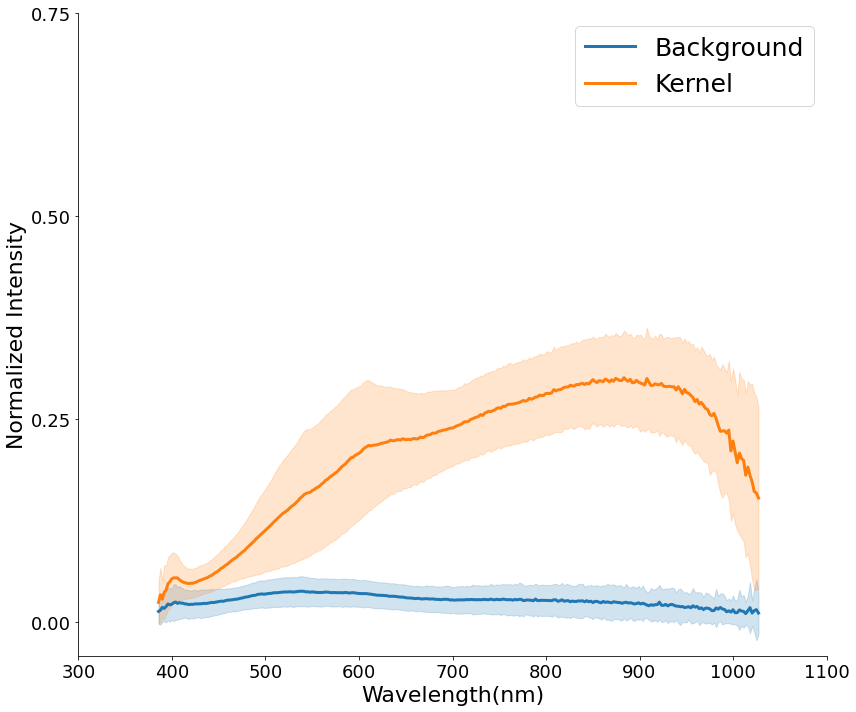

In [8]:
#wheat_cmap = ListedColormap(['#FF8C00','#9400D3'], name='organs') # Define the colormap mapping 0, and 1 to different colors
fig, ax = plt.subplots(figsize=(12, 10)) # Define a figure and a single axes object
ax = sns.lineplot(data=df_m, x='Wavelength(nm)', y='Reflectance', hue='Label', ci='sd', linewidth=3)# Provide the data, axes, labels and other details for the graph
ax.set_xlim(300, 1100) # Set x-axis numbers
ax.set_yticks([0.00, 0.25, 0.50, 0.75]) # Set y-axis numbers
plt.setp(ax.get_xticklabels(), fontsize=18) #  Fontsize of the label numbers x-axis labels
plt.setp(ax.get_yticklabels(), fontsize=18) # Fontsize of the label numbers y-axis labels
ax.set_xlabel('Wavelength(nm)', fontsize=22) ## Set name and size of x axis label
ax.set_ylabel('Normalized Intensity', fontsize=22) # Set name and size of y axis label

ax.legend(frameon=True, fontsize=25, labels=['Background','Kernel']) # Set the Index labels and put them inside the frame
ax.spines['right'].set_visible(False) # Remove x axis on right side
ax.spines['top'].set_visible(False) # Remove y axis on top
plt.tight_layout() # To cover much more space
plt.savefig('../Output/Fig2a_Curve_2_classes_initial.pdf') # Save figure as pdf
plt.show() #Display the figure